> Average Accuracy across 5-folds: 90.28% (+/- 1.27%)


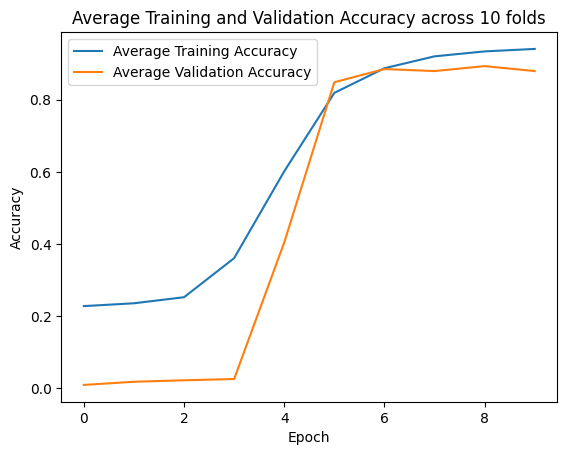

268/268 [==============================] - 6s 18ms/step


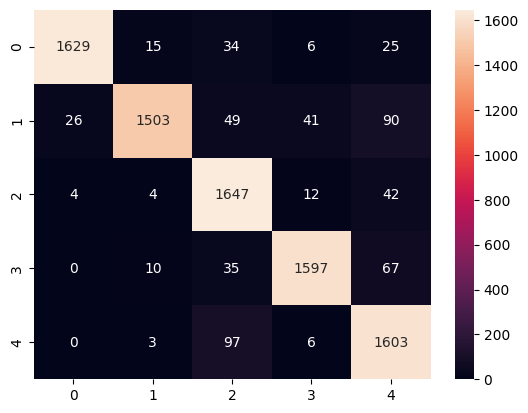

                    precision    recall  f1-score   support

             Humor       0.98      0.95      0.97      1709
          Flattery       0.98      0.88      0.93      1709
  Self Deprecation       0.88      0.96      0.92      1709
             Irony       0.96      0.93      0.95      1709
Passive Aggression       0.88      0.94      0.91      1709

          accuracy                           0.93      8545
         macro avg       0.94      0.93      0.93      8545
      weighted avg       0.94      0.93      0.93      8545



In [1]:
#GRU Model For sarcasm Annotated dataset...............



import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler

# 1. Load and Preprocess the dataset
#df = pd.read_csv('Amazon_Dataset_LD.csv', encoding='latin1')
df = pd.read_csv('Sarcasm_multiclassification.csv', encoding='latin1')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

df['comment_Text'] = df['comment_Text'].apply(clean_text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['comment_Text'])
X = tokenizer.texts_to_sequences(df['comment_Text'])
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X = pad_sequences(X, padding='post', maxlen=maxlen)
y_dict = {'Humor': 0, 'Flattery': 1, 'Self Deprecation': 2, 'Irony': 3, 'Passive Aggression': 4}
y = df['Sarcasm_Type'].map(y_dict)
y = pd.get_dummies(df['Sarcasm_Type']).values

# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the GRU model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(GRU(64))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))


> Average Accuracy across 10-folds: 90.94% (+/- 0.98%)


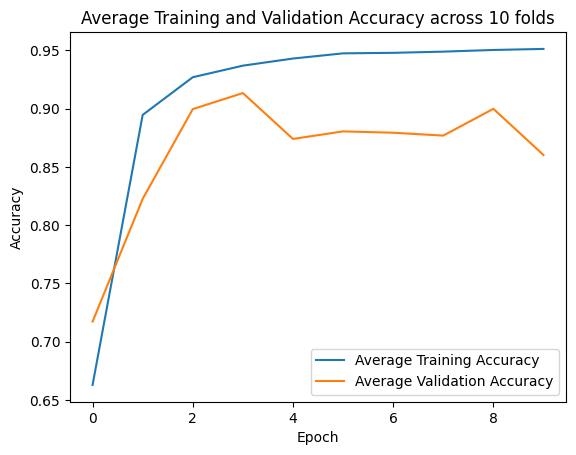

268/268 [==============================] - 6s 20ms/step


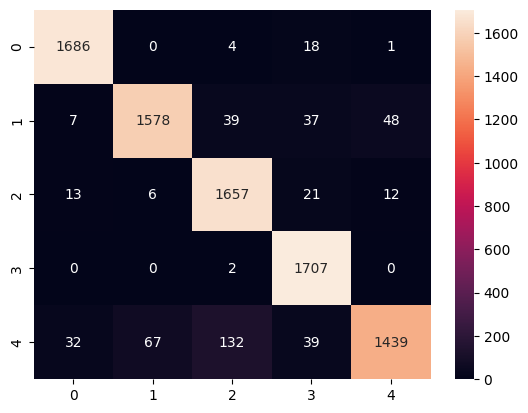

                    precision    recall  f1-score   support

             Humor       0.97      0.99      0.98      1709
          Flattery       0.96      0.92      0.94      1709
  Self Deprecation       0.90      0.97      0.94      1709
             Irony       0.94      1.00      0.97      1709
Passive Aggression       0.96      0.84      0.90      1709

          accuracy                           0.94      8545
         macro avg       0.95      0.94      0.94      8545
      weighted avg       0.95      0.94      0.94      8545



In [2]:
#BiGRU Model For sarcasm Annotated dataset...............

import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler


# 3. Define the BiGRU model
def create_bigru_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Bidirectional(GRU(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64)))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_bigru_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))


> Average Accuracy across 10-folds: 91.76% (+/- 1.08%)


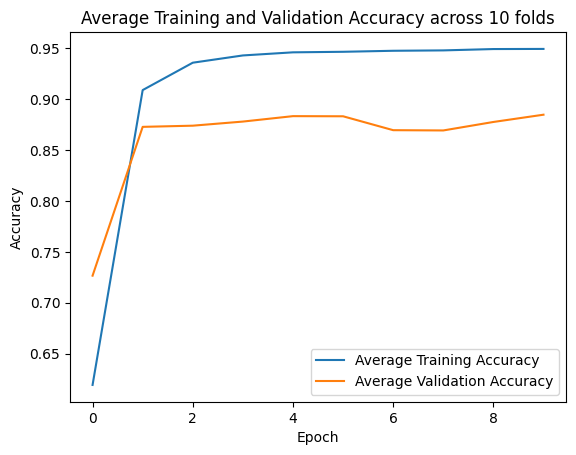

268/268 [==============================] - 2s 7ms/step


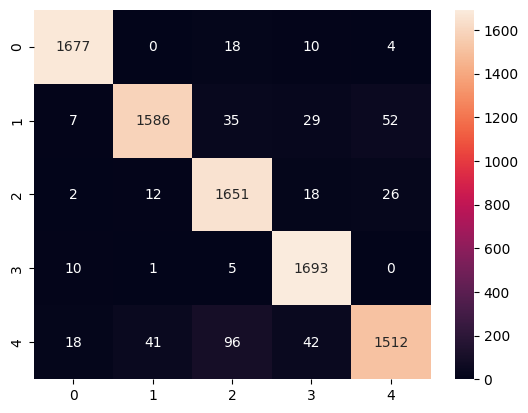

                    precision    recall  f1-score   support

             Humor       0.98      0.98      0.98      1709
          Flattery       0.97      0.93      0.95      1709
  Self Deprecation       0.91      0.97      0.94      1709
             Irony       0.94      0.99      0.97      1709
Passive Aggression       0.95      0.88      0.92      1709

          accuracy                           0.95      8545
         macro avg       0.95      0.95      0.95      8545
      weighted avg       0.95      0.95      0.95      8545



In [3]:

#CNN  Dataset , Oversampling , 


import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler



# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 10 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))



> Average Accuracy across 5-folds: 66.31% (+/- 3.52%)


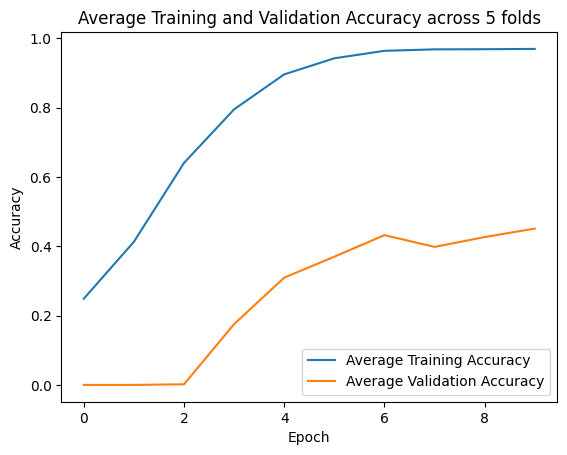

42/42 [==============================] - 0s 3ms/step


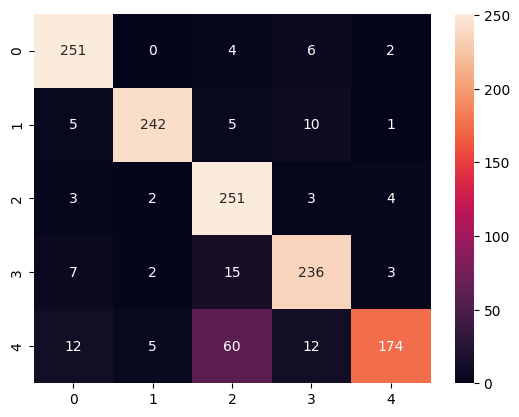

                    precision    recall  f1-score   support

             Humor       0.90      0.95      0.93       263
          Flattery       0.96      0.92      0.94       263
  Self Deprecation       0.75      0.95      0.84       263
             Irony       0.88      0.90      0.89       263
Passive Aggression       0.95      0.66      0.78       263

          accuracy                           0.88      1315
         macro avg       0.89      0.88      0.88      1315
      weighted avg       0.89      0.88      0.88      1315



In [4]:
#CNN manual annoated dataset dataset, undersampling

import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler  # Import the undersampling module


# 2. Undersample to balance classes
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 5 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_resampled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_resampled, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

# Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))









> Average Accuracy across 5-folds: 90.52% (+/- 1.06%)


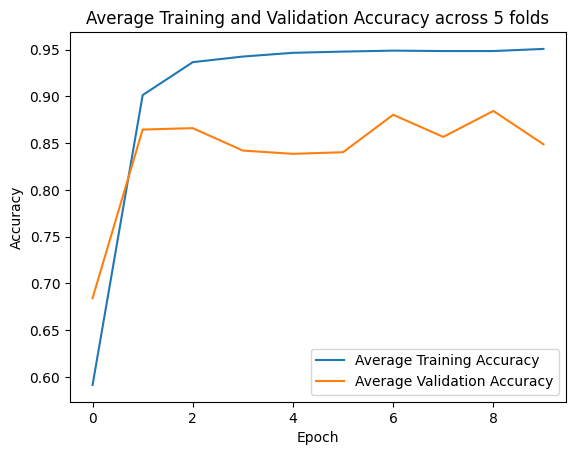

268/268 [==============================] - 1s 3ms/step


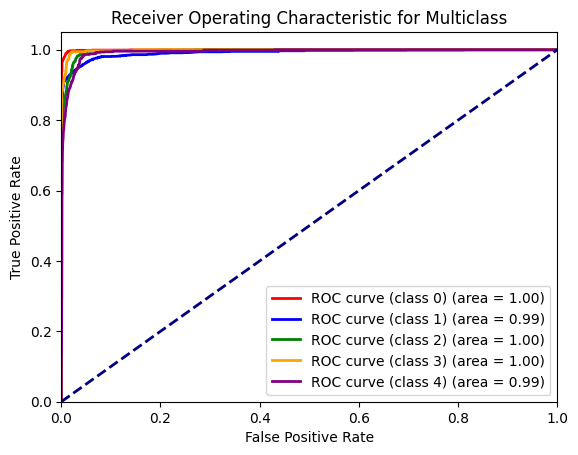

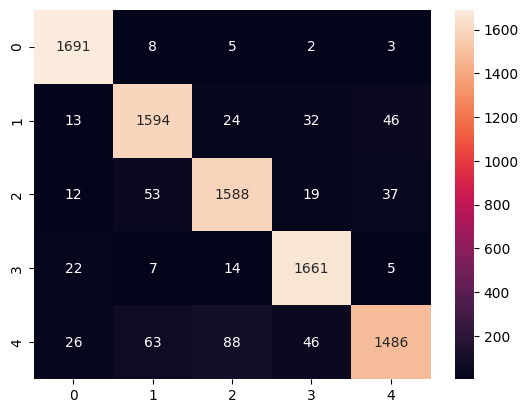

                    precision    recall  f1-score   support

             Humor       0.96      0.99      0.97      1709
          Flattery       0.92      0.93      0.93      1709
  Self Deprecation       0.92      0.93      0.93      1709
             Irony       0.94      0.97      0.96      1709
Passive Aggression       0.94      0.87      0.90      1709

          accuracy                           0.94      8545
         macro avg       0.94      0.94      0.94      8545
      weighted avg       0.94      0.94      0.94      8545



In [5]:
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc


# 2. Oversample to balance classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# 3. Define the CNN model
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. K-Fold Cross-Validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True)
fold_no = 1
acc_per_fold = []

# Lists to store average accuracies across folds
avg_train_acc = []
avg_val_acc = []

for train, test in kfold.split(X_resampled, y_resampled):
    model = create_model()
    history = model.fit(X_resampled[train], y_resampled[train], validation_split=0.1, epochs=10, batch_size=32, verbose=0)
    
    avg_train_acc.append(history.history['accuracy'])
    avg_val_acc.append(history.history['val_accuracy'])

    scores = model.evaluate(X_resampled[test], y_resampled[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    fold_no += 1

# 5. Performance Metrics
print(f'> Average Accuracy across {n_folds}-folds: {np.mean(acc_per_fold):.2f}% (+/- {np.std(acc_per_fold):.2f}%)')

# Average Training and Validation Accuracy for 5 folds
plt.plot(np.mean(avg_train_acc, axis=0), label='Average Training Accuracy')
plt.plot(np.mean(avg_val_acc, axis=0), label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy across 5 folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 6. ROC curve
y_pred = model.predict(X_resampled)
y_true_classes = np.argmax(y_resampled, axis=1)
y_pred_probs = model.predict(X_resampled)

# Binarize the true labels for ROC
y_true_binarized = label_binarize(y_true_classes, classes=[0, 1, 2, 3, 4, 5, 6, 7])

# Initialize variables to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()




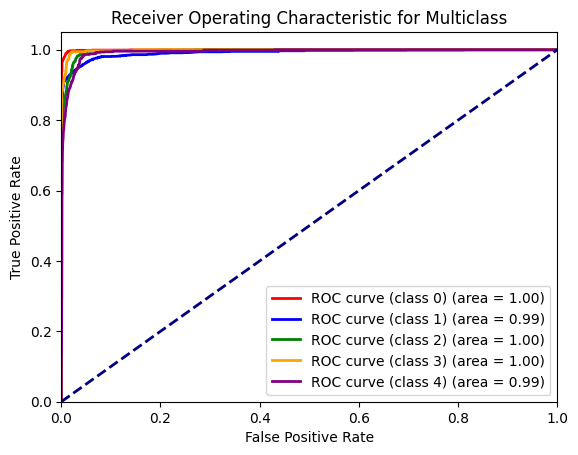

In [6]:
# Calculate ROC curve and AUC for each class
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (class {i}) (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multiclass')
plt.legend(loc='lower right')
plt.show()



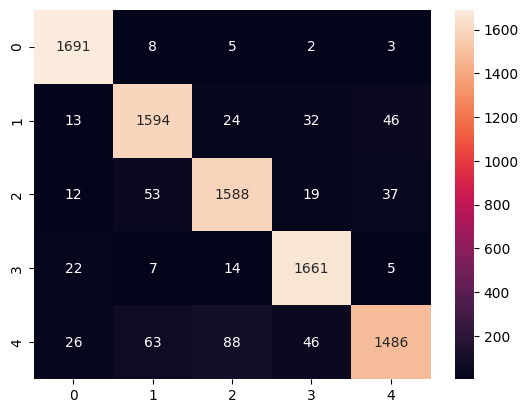

In [7]:
# 7. Confusion Matrix
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()


In [8]:

# 8. Classification Report
print(classification_report(y_true_classes, y_pred_classes, target_names=list(y_dict.keys())))

                    precision    recall  f1-score   support

             Humor       0.96      0.99      0.97      1709
          Flattery       0.92      0.93      0.93      1709
  Self Deprecation       0.92      0.93      0.93      1709
             Irony       0.94      0.97      0.96      1709
Passive Aggression       0.94      0.87      0.90      1709

          accuracy                           0.94      8545
         macro avg       0.94      0.94      0.94      8545
      weighted avg       0.94      0.94      0.94      8545

